#### Import libraries.

In [1]:

import time
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt


#### Show installed GPUs.

In [2]:

gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus :
    print("Name: ", gpu.name, " Type: ", gpu.device_type)


Name:  /physical_device:GPU:0  Type:  GPU


#### Load the dataset.

In [4]:

df = pd.read_csv('../dataset/original-sam-dataset.csv', sep='|',
                 dtype = {'recordNumber': 'int8',
                          'CZ': 'float64', 'FZ': 'float64', 'Fp1': 'float64', 'F7': 'float64',
                          'F3': 'float64', 'FC1': 'float64', 'C3': 'float64', 'FC5': 'float64', 'FT9': 'float64',
                          'T7': 'float64', 'CP5': 'float64', 'CP1': 'float64', 'P3': 'float64', 'P7': 'float64',
                          'PO9': 'float64', 'O1': 'float64', 'PZ': 'float64', 'OZ': 'float64', 'O2': 'float64',
                          'PO10': 'float64', 'P8': 'float64', 'P4': 'float64', 'CP2': 'float64', 'CP6': 'float64',
                          'T8': 'float64', 'FT10': 'float64', 'FC6': 'float64', 'C4': 'float64', 'FC2': 'float64',
                          'F4': 'float64', 'F8': 'float64', 'Fp2': 'float64', 
                          'Scale': 'int8'})


#### Display the dataset size.

In [5]:
df.shape

(1536000, 34)

#### Build a helper function to convert the set data to the required format to perform the undersampling.

In [6]:

def build_struct_for_undersamp(df):
    # Splits the dataset into "time windows" to be used as a time series list.
    # The function groups each 128 dataset records (CSV lines) into one record.
    # Each record contains 128 steps and each step contains 32 feature values.
    # Parameters:
    #    df: Dataframe to be splitted.
    # Return:
    #    X_array (list): First list contains all time windows.
    #    y_array (list): Second list contains all target values.
    print("\nStarting build_struct_for_undersamp function.")
    steps_number = 128
    initial_line_number = 0
    first_feat_index = 1
    last_feat_index = 33
    column_headers = list(df.columns.values)
    X_array = []
    y_array = []
    while initial_line_number < len(df["Scale"]):
        scale_value = df["Scale"][initial_line_number]
        sub_matrix = df.iloc[initial_line_number : (initial_line_number + steps_number), first_feat_index : last_feat_index]
        sub_matrix_values = sub_matrix.values
        new_line = sub_matrix_values.flatten()
        X_array.append(new_line)
        y_array.append(scale_value)
        initial_line_number += steps_number
    print("Quantity of samples (features) => ", len(X_array))
    print("Quantity os samples (labels) => ", len(y_array))
    print("Finishing build_struct_for_undersamp function.")
    return X_array, y_array


#### Perform undersampling to balance the dataset.

In [7]:

# Correct dataset imbalance through undersampling.
print("\nStarting undersampling process.")
X_list, y_list = build_struct_for_undersamp(df)
rus = RandomUnderSampler(random_state = 42)
X_arr = np.array(X_list)
y_arr = np.array(y_list)
X_resampled, y_resampled = rus.fit_resample(X_arr, y_arr)
print("\nQuantity of resampled samples => ", len(y_resampled))



Starting undersampling process.

Starting build_struct_for_undersamp function.
Quantity of samples (features) =>  12000
Quantity os samples (labels) =>  12000
Finishing build_struct_for_undersamp function.

Quantity of resampled samples =>  1100


#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (32) + Dense (11)
- 1100 samples (no data augmentation).

In [10]:

number_of_features = 32

def create_baseline():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (128, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(11, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data.
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X_resampled)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = scaled_X.reshape((scaled_X.shape[0], 128, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled):
    print("\nTrainning fold {}".format(fold_number))
    model = create_baseline()
    history = model.fit(X_train_reshaped[train_index], y_resampled[train_index], validation_split = 0.05,
                            epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))



Starting training at:  23:30:37

Trainning fold 1
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_90 (Conv1D)          (None, 126, 64)           6208      
                                                                 
 conv1d_91 (Conv1D)          (None, 124, 32)           6176      
                                                                 
 conv1d_92 (Conv1D)          (None, 122, 16)           1552      
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 61, 16)           0         
 g1D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 976)               0         
                                                                 
 dense_60 (Dense)            (None, 32)                31264     
  

Epoch 11/300
2/2 [==============================] - 0s 35ms/step - loss: 2.0215 - accuracy: 0.3968 - val_loss: 3.2521 - val_accuracy: 0.0000e+00
Epoch 12/300
2/2 [==============================] - 0s 34ms/step - loss: 1.9646 - accuracy: 0.3947 - val_loss: 3.3177 - val_accuracy: 0.0000e+00
Epoch 13/300
2/2 [==============================] - 0s 36ms/step - loss: 1.8973 - accuracy: 0.4106 - val_loss: 3.4122 - val_accuracy: 0.0000e+00
Epoch 14/300
2/2 [==============================] - 0s 38ms/step - loss: 1.8273 - accuracy: 0.4415 - val_loss: 3.3082 - val_accuracy: 0.0000e+00
Epoch 15/300
2/2 [==============================] - 0s 40ms/step - loss: 1.7598 - accuracy: 0.4457 - val_loss: 3.6972 - val_accuracy: 0.0000e+00
Epoch 16/300
2/2 [==============================] - 0s 38ms/step - loss: 1.6810 - accuracy: 0.4883 - val_loss: 3.7454 - val_accuracy: 0.0000e+00
Epoch 17/300
2/2 [==============================] - 0s 37ms/step - loss: 1.6172 - accuracy: 0.5096 - val_loss: 3.6812 - val_accura

2/2 [==============================] - 1s 181ms/step - loss: 2.4345 - accuracy: 0.0894 - val_loss: 2.7898 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 37ms/step - loss: 2.3800 - accuracy: 0.1170 - val_loss: 2.7841 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 37ms/step - loss: 2.3586 - accuracy: 0.1362 - val_loss: 2.7155 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 36ms/step - loss: 2.3415 - accuracy: 0.1617 - val_loss: 2.7012 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 37ms/step - loss: 2.3216 - accuracy: 0.1840 - val_loss: 2.7809 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 37ms/step - loss: 2.2968 - accuracy: 0.2074 - val_loss: 2.9224 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 37ms/step - loss: 2.2659 - accuracy: 0.2160 - val_loss: 3.0114 - val_accuracy: 0.0000e+00
Epo

2/2 [==============================] - 1s 185ms/step - loss: 2.5368 - accuracy: 0.1043 - val_loss: 2.8534 - val_accuracy: 0.0000e+00
Epoch 2/300
2/2 [==============================] - 0s 40ms/step - loss: 2.3851 - accuracy: 0.1170 - val_loss: 2.7821 - val_accuracy: 0.0000e+00
Epoch 3/300
2/2 [==============================] - 0s 42ms/step - loss: 2.3732 - accuracy: 0.1160 - val_loss: 2.6983 - val_accuracy: 0.0000e+00
Epoch 4/300
2/2 [==============================] - 0s 39ms/step - loss: 2.3680 - accuracy: 0.1511 - val_loss: 2.6633 - val_accuracy: 0.0000e+00
Epoch 5/300
2/2 [==============================] - 0s 40ms/step - loss: 2.3627 - accuracy: 0.1564 - val_loss: 2.6949 - val_accuracy: 0.0000e+00
Epoch 6/300
2/2 [==============================] - 0s 39ms/step - loss: 2.3551 - accuracy: 0.1691 - val_loss: 2.7350 - val_accuracy: 0.0000e+00
Epoch 7/300
2/2 [==============================] - 0s 40ms/step - loss: 2.3469 - accuracy: 0.1649 - val_loss: 2.7814 - val_accuracy: 0.0000e+00
Epo

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (32) + Dense (11)
- 2200 samples (with data augmentation).

In [11]:

number_of_features = 32

def create_v1():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (128, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(11, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Data augmentation (2x).
print("\nStarting data augmentation.")
X_all_oversampled = []
y_all_oversampled = []
for count in range(0, 11):
    X_oversampled, y_oversampled = resample(X_resampled[y_resampled == count],
                                            y_resampled[y_resampled == count],
                                            replace = True,
                                            n_samples = 200,
                                            random_state = 4)
    X_all_oversampled.extend(X_oversampled)
    y_all_oversampled.extend(y_oversampled)
X_resampled_arr = np.array(X_all_oversampled)
y_resampled_arr = np.array(y_all_oversampled)
print("\nQuantity of samples generated by oversampling => ", len(y_resampled_arr))


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data.
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X_resampled_arr)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = scaled_X.reshape((scaled_X.shape[0], 128, number_of_features))

# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 20)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled_arr):
    print("\nTrainning fold {}".format(fold_number))
    model = create_v1()
    history = model.fit(X_train_reshaped[train_index], y_resampled_arr[train_index], validation_split = 0.05,
                            epochs = 300, batch_size = 512, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled_arr[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled_arr[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} ".format(np.mean(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} ".format(np.mean(test_accuracy_by_fold)))



Starting data augmentation.

Quantity of samples generated by oversampling =>  2200

Starting training at:  23:31:13

Trainning fold 1
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_120 (Conv1D)         (None, 126, 64)           6208      
                                                                 
 conv1d_121 (Conv1D)         (None, 124, 32)           6176      
                                                                 
 conv1d_122 (Conv1D)         (None, 122, 16)           1552      
                                                                 
 max_pooling1d_40 (MaxPoolin  (None, 61, 16)           0         
 g1D)                                                            
                                                                 
 flatten_40 (Flatten)        (None, 976)               0         
                                                 

4/4 [==============================] - 1s 74ms/step - loss: 2.4113 - accuracy: 0.1069 - val_loss: 2.6670 - val_accuracy: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 29ms/step - loss: 2.3379 - accuracy: 0.1669 - val_loss: 2.8399 - val_accuracy: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 29ms/step - loss: 2.2849 - accuracy: 0.2275 - val_loss: 3.1925 - val_accuracy: 0.0000e+00
Epoch 4/300
4/4 [==============================] - 0s 28ms/step - loss: 2.2136 - accuracy: 0.2924 - val_loss: 3.2123 - val_accuracy: 0.0000e+00
Epoch 5/300
4/4 [==============================] - 0s 29ms/step - loss: 2.1330 - accuracy: 0.3317 - val_loss: 3.3607 - val_accuracy: 0.0000e+00
Epoch 6/300
4/4 [==============================] - 0s 29ms/step - loss: 2.0454 - accuracy: 0.3604 - val_loss: 3.3754 - val_accuracy: 0.0000e+00
Epoch 7/300
4/4 [==============================] - 0s 29ms/step - loss: 1.9447 - accuracy: 0.3939 - val_loss: 3.6015 - val_accuracy: 0.0000e+00
Epoc

4/4 [==============================] - 0s 33ms/step - loss: 0.0788 - accuracy: 0.9942 - val_loss: 3.3111 - val_accuracy: 0.4949
Epoch 36/300
4/4 [==============================] - 0s 32ms/step - loss: 0.0646 - accuracy: 0.9973 - val_loss: 3.9972 - val_accuracy: 0.4646
Epoch 37/300
4/4 [==============================] - 0s 31ms/step - loss: 0.0554 - accuracy: 0.9979 - val_loss: 3.6274 - val_accuracy: 0.4949
Epoch 38/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0468 - accuracy: 0.9984 - val_loss: 3.9500 - val_accuracy: 0.4949
Epoch 00038: early stopping

Trainning fold 7
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_138 (Conv1D)         (None, 126, 64)           6208      
                                                                 
 conv1d_139 (Conv1D)         (None, 124, 32)           6176      
                                                  

4/4 [==============================] - 1s 78ms/step - loss: 2.4165 - accuracy: 0.0946 - val_loss: 2.8714 - val_accuracy: 0.0000e+00
Epoch 2/300
4/4 [==============================] - 0s 29ms/step - loss: 2.3427 - accuracy: 0.1388 - val_loss: 2.8501 - val_accuracy: 0.0000e+00
Epoch 3/300
4/4 [==============================] - 0s 29ms/step - loss: 2.2975 - accuracy: 0.2111 - val_loss: 3.0836 - val_accuracy: 0.0000e+00
Epoch 4/300
4/4 [==============================] - 0s 29ms/step - loss: 2.2327 - accuracy: 0.2350 - val_loss: 3.0359 - val_accuracy: 0.0000e+00
Epoch 5/300
4/4 [==============================] - 0s 30ms/step - loss: 2.1461 - accuracy: 0.3099 - val_loss: 3.2412 - val_accuracy: 0.0000e+00
Epoch 6/300
4/4 [==============================] - 0s 32ms/step - loss: 2.0478 - accuracy: 0.3557 - val_loss: 3.0411 - val_accuracy: 0.0000e+00
Epoch 7/300
4/4 [==============================] - 0s 31ms/step - loss: 1.9314 - accuracy: 0.3998 - val_loss: 3.2945 - val_accuracy: 0.0000e+00
Epoc

4/4 [==============================] - 0s 38ms/step - loss: 1.1063 - accuracy: 0.7033 - val_loss: 3.0439 - val_accuracy: 0.1818
Epoch 16/300
4/4 [==============================] - 0s 38ms/step - loss: 1.0084 - accuracy: 0.7358 - val_loss: 3.0386 - val_accuracy: 0.1818
Epoch 17/300
4/4 [==============================] - 0s 39ms/step - loss: 0.9177 - accuracy: 0.7661 - val_loss: 3.0039 - val_accuracy: 0.1919
Epoch 18/300
4/4 [==============================] - 0s 39ms/step - loss: 0.8398 - accuracy: 0.7905 - val_loss: 2.7003 - val_accuracy: 0.2222
Epoch 19/300
4/4 [==============================] - 0s 38ms/step - loss: 0.7590 - accuracy: 0.8192 - val_loss: 2.9559 - val_accuracy: 0.2222
Epoch 20/300
4/4 [==============================] - 0s 39ms/step - loss: 0.6953 - accuracy: 0.8299 - val_loss: 2.8496 - val_accuracy: 0.2727
Epoch 21/300
4/4 [==============================] - 0s 39ms/step - loss: 0.6282 - accuracy: 0.8527 - val_loss: 2.9285 - val_accuracy: 0.2929
Epoch 22/300
4/4 [========

#### Train a Convolutional Neural Network model and evaluate the metrics.
- Layer architecture => Conv1D (64) + Conv1D (32) + Conv1D (16) + MaxPooling1D + Dense (32) + Dense (11)
- 6600 samples (with data augmentation).

In [11]:

number_of_features = 32

def create_v2():
    model = Sequential()
    model.add(Conv1D(filters = 64, kernel_size = 3, activation = "relu", input_shape = (128, number_of_features)))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation = "relu"))
    model.add(Conv1D(filters = 16, kernel_size = 3, activation = "relu"))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(32, activation = "relu"))
    model.add(Dense(11, activation = 'softmax'))
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    return model


# Data augmentation (6x).
print("\nStarting data augmentation.")
X_all_oversampled = []
y_all_oversampled = []
for count in range(0, 11):
    X_oversampled, y_oversampled = resample(X_resampled[y_resampled == count],
                                            y_resampled[y_resampled == count],
                                            replace = True,
                                            n_samples = 600,
                                            random_state = 42)
    X_all_oversampled.extend(X_oversampled)
    y_all_oversampled.extend(y_oversampled)
X_resampled_arr = np.array(X_all_oversampled)
y_resampled_arr = np.array(y_all_oversampled)
print("\nQuantity of samples generated by oversampling => ", len(y_resampled_arr))


# Defining the number of folds (10 k-Fold).
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Normalize data.
scaler = RobustScaler()
scaled_X = scaler.fit_transform(X_resampled_arr)

# Reshape the structure data to be compatible with pattern [samples, timesteps, features].
X_train_reshaped = scaled_X.reshape((scaled_X.shape[0], 128, number_of_features))


# Train the CNN model and evaluate it.
start_time = time.time()
print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 30)

train_accuracy_by_fold = []
test_accuracy_by_fold = []
history_by_fold = []
y_predclass_for_report = []
y_testclass_for_report = []
predictedclass = []
fold_number = 1
for train_index, test_index in skf.split(X_train_reshaped, y_resampled_arr):
    print("\nTrainning fold {}".format(fold_number))
    model = create_v2()
    history = model.fit(X_train_reshaped[train_index], y_resampled_arr[train_index], validation_split = 0.05,
                            epochs = 300, batch_size = 32, verbose = 1, callbacks = [es])
    _, train_accuracy = model.evaluate(X_train_reshaped[train_index], y_resampled_arr[train_index], verbose = 0)
    _, test_accuracy = model.evaluate(X_train_reshaped[test_index], y_resampled_arr[test_index], verbose = 0)
    train_accuracy_by_fold.append(train_accuracy)
    test_accuracy_by_fold.append(test_accuracy)
    history_by_fold.append(history)
    y_predclass_for_report.extend(np.argmax(model.predict(X_train_reshaped[test_index]), axis = 1))
    y_testclass_for_report.extend(y_resampled_arr[test_index])
    fold_number += 1

elapsed_seconds = time.time() - start_time
print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
print("\n")

# Show metrics.
for i in range(len(train_accuracy_by_fold)):
    print("Fold {} - Train Accuracy {:.4f} - Test Accuracy {:.4f}".format((i + 1),
                            train_accuracy_by_fold[i], test_accuracy_by_fold[i]))
print("\nMean Train Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(train_accuracy_by_fold), np.std(train_accuracy_by_fold)))
print("Mean Test Accuracy: {:.4f} - Std: {:.4f} ".format(np.mean(test_accuracy_by_fold), np.std(test_accuracy_by_fold)))

print("\nEvaluate other metrics:")
print(classification_report(y_testclass_for_report, y_predclass_for_report))



Starting data augmentation.

Quantity of samples generated by oversampling =>  6600

Starting training at:  23:45:14

Trainning fold 1
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_90 (Conv1D)          (None, 126, 64)           6208      
                                                                 
 conv1d_91 (Conv1D)          (None, 124, 32)           6176      
                                                                 
 conv1d_92 (Conv1D)          (None, 122, 16)           1552      
                                                                 
 max_pooling1d_30 (MaxPoolin  (None, 61, 16)           0         
 g1D)                                                            
                                                                 
 flatten_30 (Flatten)        (None, 976)               0         
                                                 

177/177 [==============================] - 1s 7ms/step - loss: 0.2946 - accuracy: 0.9343 - val_loss: 2.0573 - val_accuracy: 0.5455
Epoch 4/300
177/177 [==============================] - 1s 7ms/step - loss: 0.0835 - accuracy: 0.9876 - val_loss: 0.4381 - val_accuracy: 0.9226
Epoch 5/300
177/177 [==============================] - 2s 9ms/step - loss: 0.0234 - accuracy: 0.9975 - val_loss: 0.4637 - val_accuracy: 0.9495
Epoch 6/300
177/177 [==============================] - 1s 7ms/step - loss: 0.0079 - accuracy: 0.9995 - val_loss: 0.5491 - val_accuracy: 0.9495
Epoch 7/300
177/177 [==============================] - 1s 7ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.5336 - val_accuracy: 0.9495
Epoch 8/300
177/177 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5697 - val_accuracy: 0.9495
Epoch 9/300
177/177 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6302 - val_accuracy: 0.9495
Epoch 10/30

177/177 [==============================] - 1s 6ms/step - loss: 2.9443e-04 - accuracy: 1.0000 - val_loss: 1.1244 - val_accuracy: 0.9057
Epoch 16/300
177/177 [==============================] - 1s 7ms/step - loss: 2.4933e-04 - accuracy: 1.0000 - val_loss: 1.1184 - val_accuracy: 0.9057
Epoch 17/300
177/177 [==============================] - 1s 7ms/step - loss: 2.1417e-04 - accuracy: 1.0000 - val_loss: 1.1713 - val_accuracy: 0.9057
Epoch 18/300
177/177 [==============================] - 1s 7ms/step - loss: 1.8405e-04 - accuracy: 1.0000 - val_loss: 1.1865 - val_accuracy: 0.9057
Epoch 19/300
177/177 [==============================] - 1s 6ms/step - loss: 1.5889e-04 - accuracy: 1.0000 - val_loss: 1.2074 - val_accuracy: 0.9057
Epoch 20/300
177/177 [==============================] - 1s 6ms/step - loss: 1.3771e-04 - accuracy: 1.0000 - val_loss: 1.2226 - val_accuracy: 0.9057
Epoch 21/300
177/177 [==============================] - 1s 7ms/step - loss: 1.1969e-04 - accuracy: 1.0000 - val_loss: 1.2085 

Epoch 27/300
177/177 [==============================] - 2s 9ms/step - loss: 5.3422e-05 - accuracy: 1.0000 - val_loss: 0.4594 - val_accuracy: 0.9562
Epoch 28/300
177/177 [==============================] - 1s 8ms/step - loss: 4.7601e-05 - accuracy: 1.0000 - val_loss: 0.4564 - val_accuracy: 0.9562
Epoch 29/300
177/177 [==============================] - 1s 8ms/step - loss: 4.2163e-05 - accuracy: 1.0000 - val_loss: 0.4712 - val_accuracy: 0.9562
Epoch 30/300
177/177 [==============================] - 1s 8ms/step - loss: 3.7435e-05 - accuracy: 1.0000 - val_loss: 0.4765 - val_accuracy: 0.9562
Epoch 31/300
177/177 [==============================] - 1s 7ms/step - loss: 3.3478e-05 - accuracy: 1.0000 - val_loss: 0.4727 - val_accuracy: 0.9562
Epoch 32/300
177/177 [==============================] - 1s 7ms/step - loss: 2.9745e-05 - accuracy: 1.0000 - val_loss: 0.4805 - val_accuracy: 0.9562
Epoch 33/300
177/177 [==============================] - 1s 7ms/step - loss: 2.6610e-05 - accuracy: 1.0000 - val_

Epoch 1/300
177/177 [==============================] - 4s 10ms/step - loss: 2.1588 - accuracy: 0.2566 - val_loss: 2.7931 - val_accuracy: 0.0505
Epoch 2/300
177/177 [==============================] - 1s 7ms/step - loss: 1.2129 - accuracy: 0.6376 - val_loss: 2.2800 - val_accuracy: 0.3098
Epoch 3/300
177/177 [==============================] - 1s 7ms/step - loss: 0.4908 - accuracy: 0.8721 - val_loss: 1.1094 - val_accuracy: 0.6700
Epoch 4/300
177/177 [==============================] - 1s 7ms/step - loss: 0.1545 - accuracy: 0.9722 - val_loss: 1.1165 - val_accuracy: 0.6599
Epoch 5/300
177/177 [==============================] - 1s 8ms/step - loss: 0.0615 - accuracy: 0.9906 - val_loss: 0.2607 - val_accuracy: 0.9394
Epoch 6/300
177/177 [==============================] - 2s 9ms/step - loss: 0.0156 - accuracy: 0.9989 - val_loss: 0.2474 - val_accuracy: 0.9529
Epoch 7/300
177/177 [==============================] - 1s 7ms/step - loss: 0.0051 - accuracy: 0.9998 - val_loss: 0.2038 - val_accuracy: 0.966

177/177 [==============================] - 1s 8ms/step - loss: 5.9701e-04 - accuracy: 1.0000 - val_loss: 0.6111 - val_accuracy: 0.9394
Epoch 11/300
177/177 [==============================] - 1s 7ms/step - loss: 4.6956e-04 - accuracy: 1.0000 - val_loss: 0.6364 - val_accuracy: 0.9394
Epoch 12/300
177/177 [==============================] - 1s 8ms/step - loss: 3.7880e-04 - accuracy: 1.0000 - val_loss: 0.6368 - val_accuracy: 0.9394
Epoch 13/300
177/177 [==============================] - 1s 7ms/step - loss: 3.1114e-04 - accuracy: 1.0000 - val_loss: 0.6645 - val_accuracy: 0.9394
Epoch 14/300
177/177 [==============================] - 1s 7ms/step - loss: 2.5631e-04 - accuracy: 1.0000 - val_loss: 0.6728 - val_accuracy: 0.9394
Epoch 15/300
177/177 [==============================] - 1s 7ms/step - loss: 2.1528e-04 - accuracy: 1.0000 - val_loss: 0.6944 - val_accuracy: 0.9394
Epoch 16/300
177/177 [==============================] - 1s 8ms/step - loss: 1.8204e-04 - accuracy: 1.0000 - val_loss: 0.7015 

Epoch 22/300
177/177 [==============================] - 1s 7ms/step - loss: 9.6747e-05 - accuracy: 1.0000 - val_loss: 0.3395 - val_accuracy: 0.9596
Epoch 23/300
177/177 [==============================] - 1s 7ms/step - loss: 8.4598e-05 - accuracy: 1.0000 - val_loss: 0.3440 - val_accuracy: 0.9596
Epoch 24/300
177/177 [==============================] - 1s 7ms/step - loss: 7.4391e-05 - accuracy: 1.0000 - val_loss: 0.3474 - val_accuracy: 0.9596
Epoch 25/300
177/177 [==============================] - 1s 7ms/step - loss: 6.5636e-05 - accuracy: 1.0000 - val_loss: 0.3468 - val_accuracy: 0.9596
Epoch 26/300
177/177 [==============================] - 1s 7ms/step - loss: 5.7969e-05 - accuracy: 1.0000 - val_loss: 0.3534 - val_accuracy: 0.9596
Epoch 27/300
177/177 [==============================] - 1s 7ms/step - loss: 5.1300e-05 - accuracy: 1.0000 - val_loss: 0.3511 - val_accuracy: 0.9596
Epoch 28/300
177/177 [==============================] - 1s 7ms/step - loss: 4.5527e-05 - accuracy: 1.0000 - val_

Epoch 32/300
177/177 [==============================] - 1s 8ms/step - loss: 2.4686e-05 - accuracy: 1.0000 - val_loss: 1.7316 - val_accuracy: 0.9293
Epoch 33/300
177/177 [==============================] - 1s 7ms/step - loss: 2.2066e-05 - accuracy: 1.0000 - val_loss: 1.7504 - val_accuracy: 0.9293
Epoch 34/300
177/177 [==============================] - 1s 6ms/step - loss: 1.9732e-05 - accuracy: 1.0000 - val_loss: 1.7626 - val_accuracy: 0.9293
Epoch 35/300
177/177 [==============================] - 1s 7ms/step - loss: 1.7668e-05 - accuracy: 1.0000 - val_loss: 1.7795 - val_accuracy: 0.9293
Epoch 36/300
177/177 [==============================] - 1s 6ms/step - loss: 1.5846e-05 - accuracy: 1.0000 - val_loss: 1.7969 - val_accuracy: 0.9293
Epoch 00036: early stopping

Trainning fold 10
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_117 (Conv1D)         (None, 126, 64)           620

#### Show loss history by epochs.

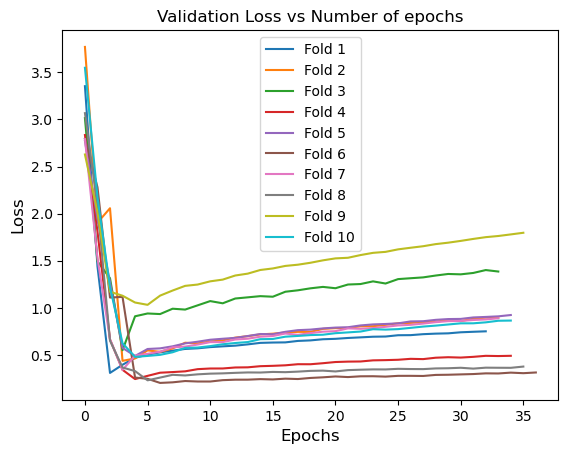

In [12]:

# Plot loss history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_loss"], label = "Fold {}".format(i + 1))
plt.title("Validation Loss vs Number of epochs", fontsize = 12)
plt.xlabel("Epochs", fontsize = 12)
plt.ylabel("Loss", fontsize = 12)
plt.legend()
plt.show()


#### Show accuracy history by epochs.

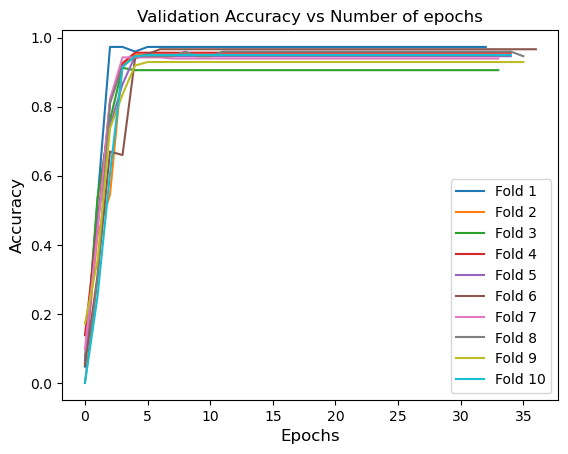

In [13]:

# Plot accuracy history
for i in range(len(history_by_fold)):
    plt.plot(history_by_fold[i].history["val_accuracy"], label = "Fold {}".format(i + 1))
plt.title("Validation Accuracy vs Number of epochs", fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Accuracy', fontsize = 12)
plt.legend()
plt.show()
